<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>
    ДИСЦИПЛИНА <br>
        «Модели и методы обработки статистической информации в автоматизированном управлении НГО»
    <br><br> <br> <br> <br> <br> <br><br>
    ОТЧЁТ <br>
    по лабораторной работе №5 <br>
    «Статистический анализ многомерных выборок. Классификация и снижение размерности»<br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br>  <br> <br> <br> <br> <br> <br><br>
</p>

<p style="text-align: right;">
    Выполнил: студент группы АС-21-05, Негробов В.А.<br>
    Проверила: старший преподаватель, Степанкина О.А.<br><br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br> <br> <br><br><br> <br> <br> <br> <br><br>
</p>

<p style="text-align: center;">
    МОСКВА 2024
</p>

Задание:
1. Классификация данных

1.1.Дискриминантный анализ.

1.1.1. Построить классификационное правило, используя обучающую выборку (p = 8; k = 2).

1.1.2. Провести оценку качества построенного правила.

1.1.3. Провести классификацию 10 новых объектов.

1.2. Кластерный анализ (p = 8)

1.2.1. Провести классификацию, используя различные метрики и алгоритмы кластерного анализа.

1.2.2. Сравнить результаты кластеризации с классификацией полученной другими методами.

1.2.3. Определить характеристики случайных величин, представляющих полученные классы. Построить регрессионную модель для каждого кластера.

2. Снижение размерности. Метод главных компонент (p = 8; p’ = 2)

2.1. Найти выражение для двух главных компонент Z1 , Z2.

2.2. Определить основные характеристики компонент.

2.3. Провести визуальную классификацию данных, спроектированных в пространство первых двух главных компонент.

2.4. Какую часть дисперсии объясняют эти компоненты.

2.5. Сколько компонент необходимо для объяснения 90% дисперсии (p’-?). 

Подключение библиотек

In [126]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.cluster.vq import whiten, kmeans, vq
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from bioinfokit.visuz import cluster

Функция, выполняющая рассчёт основных статистических показателей

In [127]:
def get_info(df):
    columns = ['count', 'nunique', 'mean',  'range',  'std', 'varience', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurt', 'sem', 'sum']
    info = df.describe().T
    info['nunique'] = df.nunique()
    info['range'] = df.max(0) - df.min(0)
    info['varience'] = df.var()
    info['skew'] = df.skew()
    info['kurt'] = df.kurtosis()
    info['sem'] = df.sem()
    info['sum'] = df.sum()
    mode = df.mode(axis=0).T
    mode_names = [f'mode{i + 1}' for i in range(len(mode.T))]
    mode.columns = [f'mode{i + 1}' for i in range(len(mode.T))]
    columns = columns + mode_names[:3]
    info = pd.concat([info, mode], axis=1)
    return info[columns]

Считывание данных

In [128]:
column_names = [f'var{i + 1}' for i in range(8)]

df = pd.read_excel('ms-data3.xlsx', '3', header=None,
                   names=column_names + ['None'] + ['cls'])
df = df.drop('None', axis=1)
df_train = df.iloc[1:21]
df_train['index'] = range(20)
df_train = df_train.set_index('index')
df_train['cls'] = df_train['cls'].values - 1

C:\Users\vikto\AppData\Local\Temp\ipykernel_23180\1572387737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = range(20)


In [129]:
df_train

,var1,var2,var3,var4,var5,var6,var7,var8,cls
index,,,,,,,,,
0,13.829,13.054,2.072,9.316,-75.047,0.728,-5.127,0.520,0
1,13.595,14.198,1.949,4.541,23.833,-0.557,8.205,2.712,0
2,15.199,12.208,2.295,6.440,-7.980,3.087,4.551,1.538,0
3,3.449,2.002,2.870,7.656,-36.830,0.339,-2.888,1.273,0
4,9.297,1.674,7.481,6.199,-2.556,4.813,4.066,0.943,0
5,13.285,17.957,1.687,4.993,5.851,-4.215,5.515,1.177,0
6,6.74,-4.922,-0.852,2.361,1.984,5.337,1.861,0.683,0
7,7.929,7.038,2.152,9.282,-72.814,0.480,-6.536,1.354,0
8,4.929,-0.397,-14.155,4.212,-1.863,1.782,-0.630,1.036,0


In [130]:
df_test = df.iloc[22:, :-1]
df_test['index'] = range(10)
df_test = df_test.set_index('index')

In [131]:
df_test

,var1,var2,var3,var4,var5,var6,var7,var8
index,,,,,,,,
0,7.067112,14.126164,1.398492,12.248382,15.720863,-3.387396,6.533666,-0.731764
1,5.404137,21.548591,22.137885,8.843795,-5.157064,16.663980,9.734781,10.677927
2,1.821365,27.883897,14.096621,11.050607,-24.370467,10.914315,5.736915,11.610423
3,4.459267,3.676102,2.256440,2.327041,-1.380254,0.237134,1.676466,0.455382
4,3.838606,33.584304,14.948935,8.628067,-33.720832,11.061429,5.259817,11.713002
5,6.16695,2.178221,4.204207,4.956740,-4.611220,1.670255,2.196810,1.973321
6,2.394137,27.222858,15.018086,11.618131,-21.099159,11.423781,6.463490,10.750459
7,9.099304,2.970610,4.483372,2.367415,2.432537,3.786637,3.769759,0.949605
8,4.976684,26.629139,18.619270,8.900759,-9.059375,14.223080,8.929193,11.923076


# 1. Классификация данных 

## 1.1.Дискриминантный анализ

### 1.1.1. Построить классификационное правило, используя обучающую выборку (p = 8; k = 2).

In [132]:
df_train1 = df_train.loc[df_train['cls'] == 0][column_names]
df_train2 = df_train.loc[df_train['cls'] == 1][column_names]

n1, n2 = len(df_train1), len(df_train2)
mean1, mean2 = df_train1.mean(), df_train2.mean()
cov1, cov2 = df_train1.cov(), df_train2.cov()
unestablished_estimates = np.linalg.inv((n1*cov1 + n2*cov2) / (n1 + n2 - 2))
unestablished_estimates
coeffs = unestablished_estimates @ (mean1 - mean2)
mean = (np.mean(df_train1.values @ coeffs) + np.mean(df_train2.values @ coeffs)) / 2

### 1.1.2. Провести оценку качества построенного правила. 

In [133]:
classes = (df_train[column_names] @ coeffs - mean) < 0
(classes == df_train['cls']).mean() * 100

100.0

In [134]:
clf = LogisticRegression(random_state=0, solver='liblinear').fit(df_train[column_names], df_train['cls'].astype(int))
y_test = clf.predict(df_test[column_names])
classes = (df_test[column_names] @ coeffs - mean) < 0
(classes == y_test).mean() * 100

100.0

### 1.1.3. Провести классификацию 10 новых объектов. 

In [135]:
classes.astype(int)

index
0    0
1    1
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    0
dtype: int32

## 1.2. Кластерный анализ (p = 8)

### 1.2.1. Провести классификацию, используя различные метрики и алгоритмы кластерного анализа.
### 1.2.2. Сравнить результаты кластеризации с классификацией полученной другими методами. 

In [136]:
for n_clust in range(2, 10):    
    data = whiten(df_train[column_names].values.astype(float))
    centroids, mean_value = kmeans(data, n_clust)
    clusters, distances = vq(data, centroids)
    print(f'{n_clust = }, {silhouette_score(data, clusters) = }')

n_clust = 2, silhouette_score(data, clusters) = 0.41690851141777685
n_clust = 3, silhouette_score(data, clusters) = 0.34993259277881567
n_clust = 4, silhouette_score(data, clusters) = 0.3151807648849406
n_clust = 5, silhouette_score(data, clusters) = 0.2967466176721462
n_clust = 6, silhouette_score(data, clusters) = 0.30886096459021595
n_clust = 7, silhouette_score(data, clusters) = 0.31613127559194065
n_clust = 8, silhouette_score(data, clusters) = 0.3000605118206221
n_clust = 9, silhouette_score(data, clusters) = 0.25918632364847977


In [137]:
data = whiten(df_train[column_names].values.astype(float))
centroids, mean_value = kmeans(data, 2)
100 - (vq(data, centroids)[0] == df_train['cls']).mean() * 100

100.0

In [138]:
data = whiten(df_test[column_names].values.astype(float))
centroids, mean_value = kmeans(data, 2)
(vq(data, centroids)[0] == y_test).mean() * 100

0.0

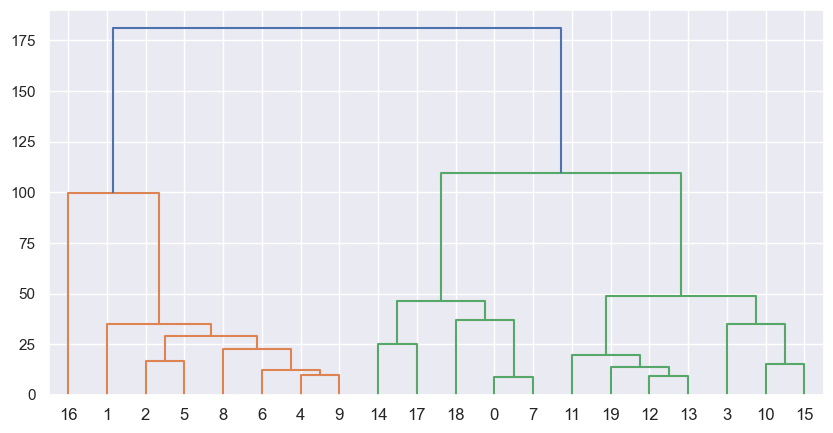

In [139]:
Z = linkage(df_train[column_names], method='ward')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z)

In [140]:
clusters = fcluster(Z, 120, criterion="distance") - 1
(clusters == df_train['cls']).mean() * 100

80.0

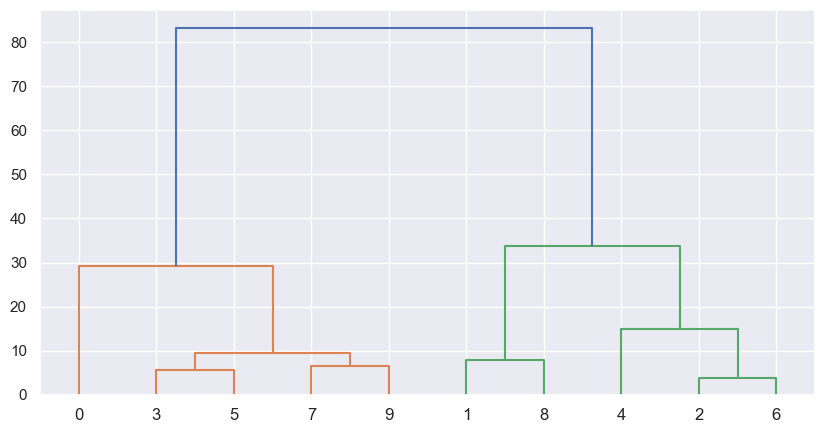

In [141]:
Z = linkage(df_test[column_names], method='ward')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z)

In [142]:
clusters = fcluster(Z, 60, criterion="distance") - 1
(clusters == y_test).mean() * 100

100.0

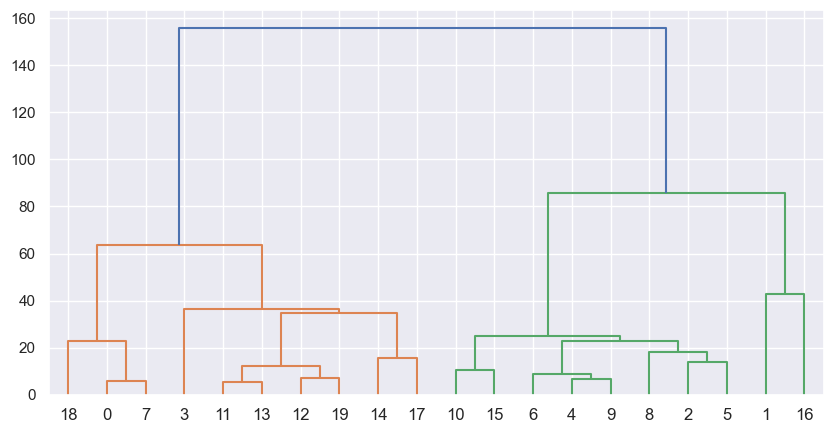

In [143]:
Z = linkage(df_train[column_names], method='complete', metric='chebyshev')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z)

In [144]:
clusters = fcluster(Z, 120, criterion="distance") - 1
100 - (clusters == df_train['cls']).mean() * 100

70.0

### 1.2.3. Определить характеристики случайных величин, представляющих полученные классы. Построить регрессионную модель для каждого кластера. 

In [145]:
get_info(df_train[column_names][clusters == 0])

,count,nunique,mean,range,std,varience,min,25%,50%,75%,max,skew,kurt,sem,sum,mode1,mode2,mode3
var2,10.0,10.0,23.7017,36.261,12.549477,157.489362,2.002,15.45800,26.6185,32.41825,38.263,-0.635882,-0.772091,3.968493,237.017,2.002,7.038,13.054
var3,10.0,10.0,9.8095,17.92,6.607734,43.662145,2.072,3.32125,10.0800,15.41475,19.992,0.111321,-1.582339,2.089549,98.095,2.072,2.152,2.87
var4,10.0,10.0,10.1983,7.748,2.592924,6.723256,6.457,8.06250,9.9505,12.10550,14.205,0.09058,-1.210059,0.819955,101.983,6.457,7.489,7.656
var5,10.0,10.0,-50.1715,63.572,23.092027,533.241711,-89.128,-69.67375,-44.7620,-30.16825,-25.556,-0.493144,-1.340762,7.30234,-501.715,-89.128,-75.047,-72.814
var6,10.0,10.0,7.8300,14.954,5.355895,28.685612,0.339,2.68625,9.6765,10.88375,15.293,-0.565641,-1.110841,1.693683,78.3,0.339,0.48,0.728
var7,10.0,10.0,0.7197,16.136,5.545143,30.748615,-6.536,-3.54575,0.1780,5.10475,9.600,0.242707,-1.425936,1.753528,7.197,-6.536,-5.127,-3.765
var8,10.0,10.0,8.3299,12.387,5.111882,26.131342,0.520,3.35700,11.1020,11.90950,12.907,-0.925029,-1.263231,1.616519,83.299,0.52,1.273,1.354
var1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.346,-1.843,-0.776


In [146]:
get_info(df_train[column_names][clusters == 1])

,count,nunique,mean,range,std,varience,min,25%,50%,75%,max,skew,kurt,sem,sum,mode1,mode2,mode3
var2,10.0,10.0,11.0911,40.965,11.906335,141.760805,-4.922,2.22150,11.6425,17.01725,36.043,0.78915,0.961164,3.765114,110.911,-4.922,-0.397,1.674
var3,10.0,10.0,2.4566,24.034,6.793744,46.154958,-14.155,1.75250,2.7415,6.60300,9.879,-1.676318,4.053816,2.14837,24.566,-14.155,-0.852,1.687
var4,10.0,10.0,6.5101,14.717,4.337650,18.815212,1.683,4.29425,5.5960,7.20050,16.400,1.431067,2.318794,1.371686,65.101,1.683,2.361,4.212
var5,10.0,10.0,6.2088,85.714,24.000209,576.010028,-19.132,-6.62400,0.0605,5.38850,66.582,2.027887,4.800254,7.589532,62.088,-19.132,-8.632,-7.98
var6,10.0,10.0,3.6200,14.735,4.176733,17.445102,-4.215,1.83375,3.9500,5.95725,10.520,-0.312198,0.38688,1.320799,36.2,-4.215,-0.557,1.782
var7,10.0,10.0,5.1148,19.065,5.238856,27.445607,-0.630,2.27475,3.9850,5.27400,18.435,2.055175,5.190472,1.656672,51.148,-0.63,1.861,1.929
var8,10.0,10.0,3.9452,11.935,4.613716,21.286377,-0.156,0.96625,1.3575,7.92525,11.779,0.998173,-1.019426,1.458985,39.452,-0.156,0.683,0.943
var1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.536,-3.056,-1.544


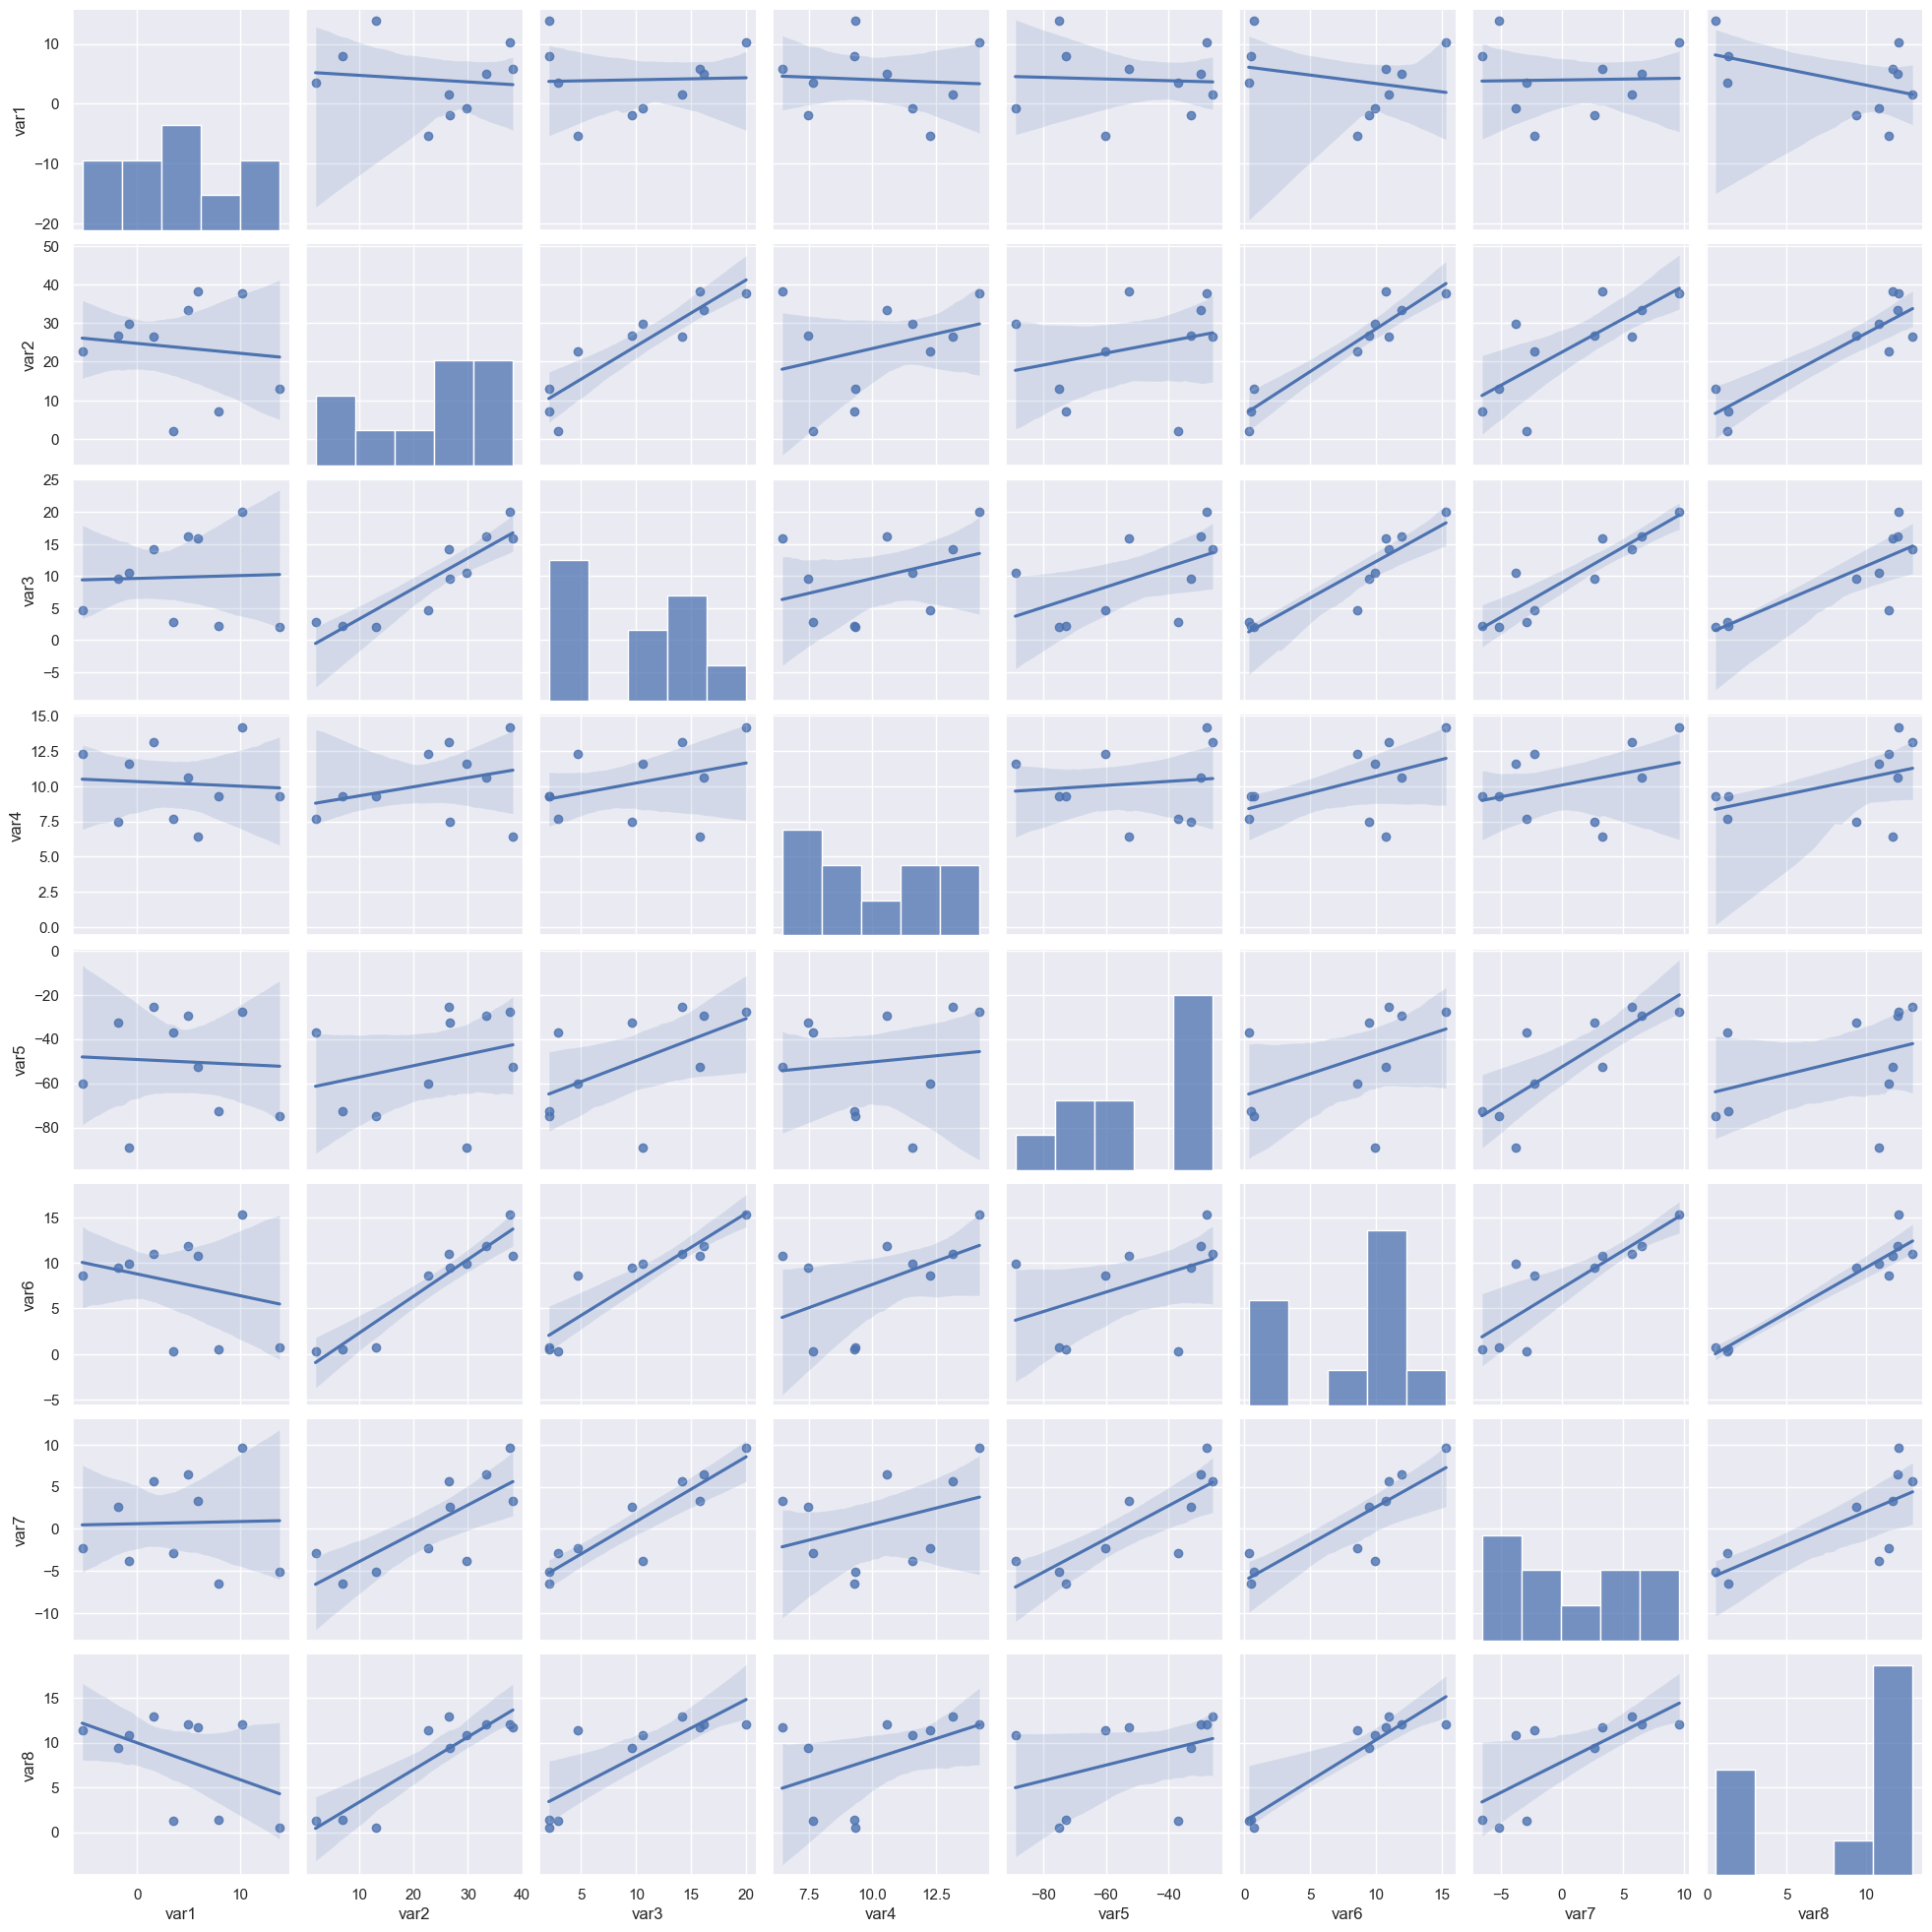

In [147]:
g = sns.pairplot(df_train[column_names][clusters == 0].astype(float), kind="reg")

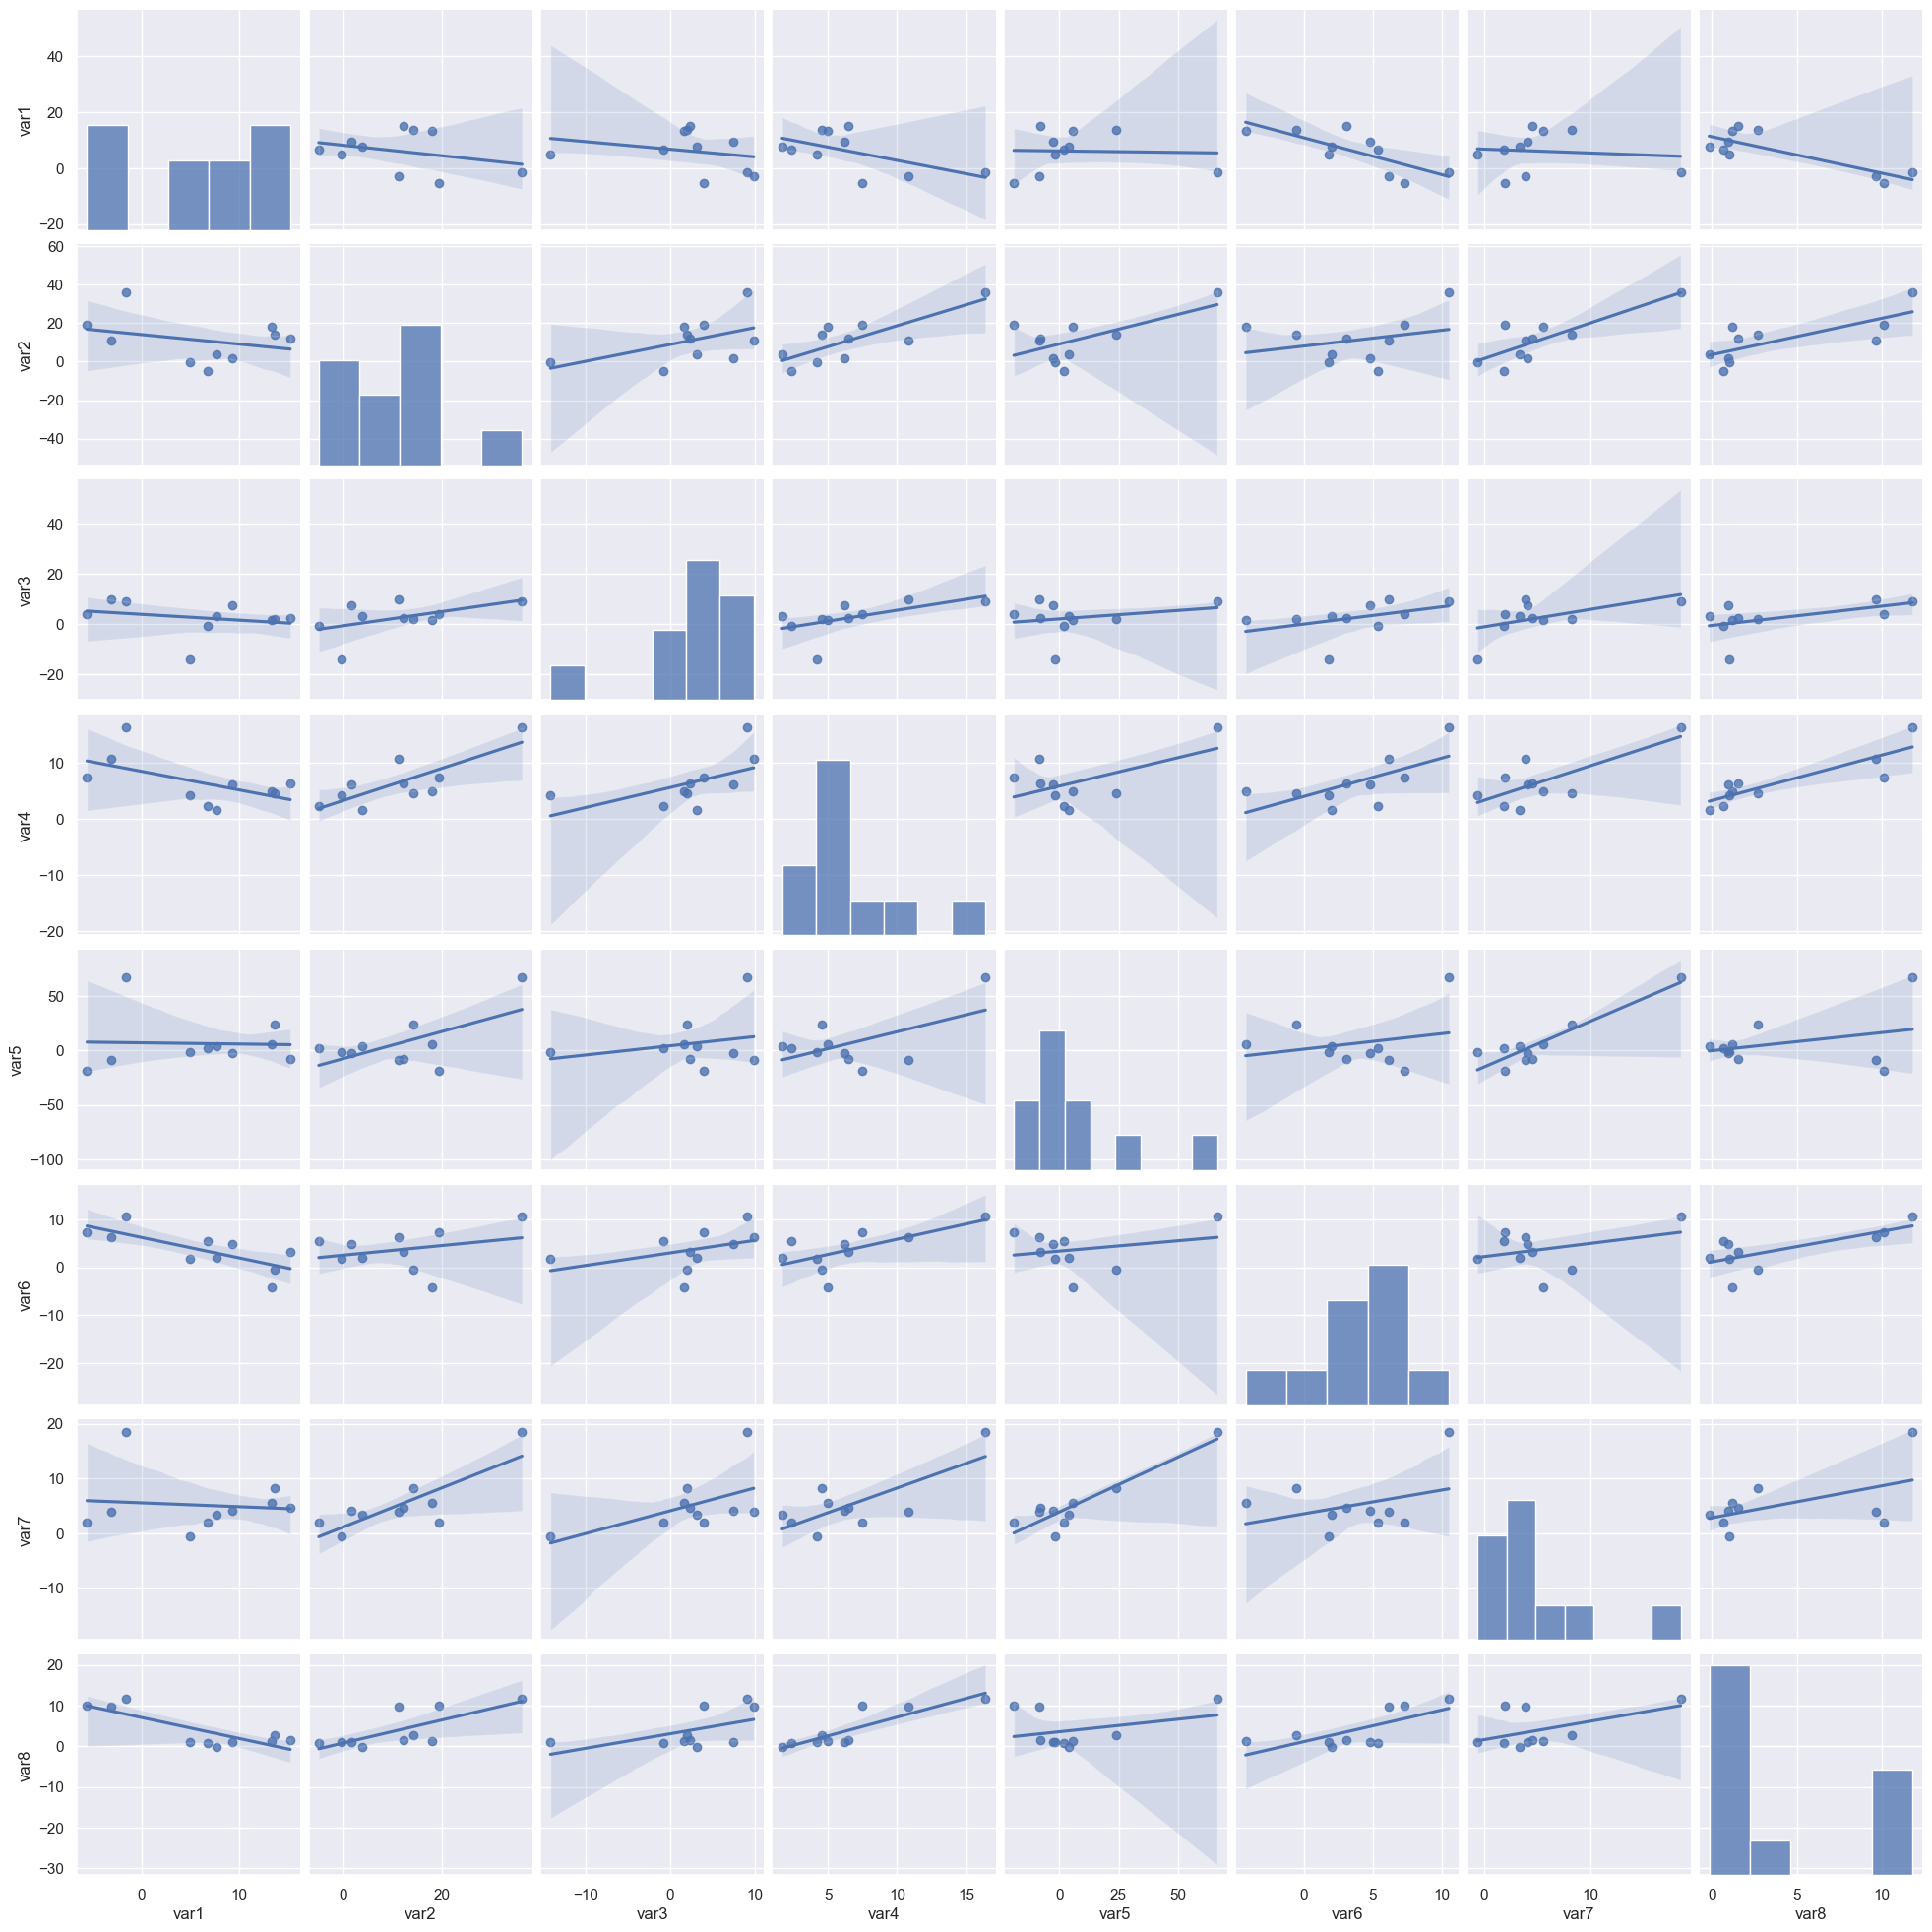

In [148]:
g = sns.pairplot(df_train[column_names][clusters == 1].astype(float), kind="reg")

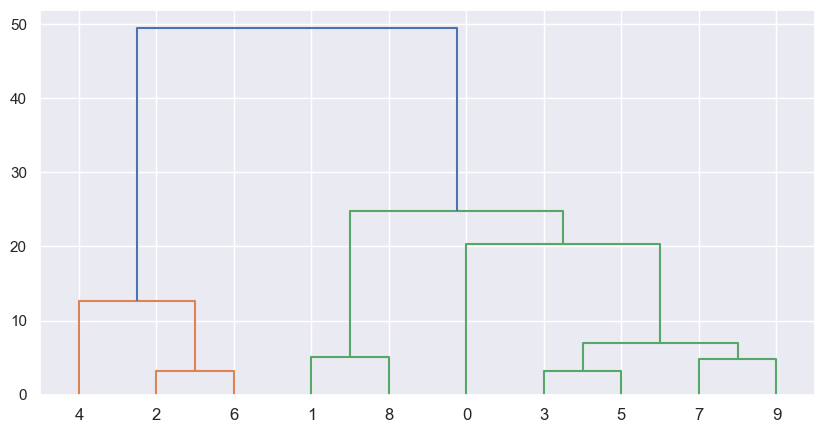

In [149]:
Z = linkage(df_test[column_names], method='complete', metric='chebyshev')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z)

In [150]:
clusters = fcluster(Z, 40, criterion="distance") - 1
100 - (clusters == y_test).mean() * 100

80.0

# 2. Снижение размерности. Метод главных компонент (p = 8; p’ = 2)

## 2.1. Найти выражение для двух главных компонент Z1 , Z2. 

In [151]:
stand_scaler = StandardScaler()
stand_scaler = stand_scaler.fit(df_train[column_names])
df_train_norm = stand_scaler.transform(df_train[column_names])  

pca = PCA(n_components=2)
pca.fit(df_train_norm)
df_train2c = pd.DataFrame(
    np.column_stack((pca.transform(df_train_norm), df_train['cls'])
                  ), columns=['var1', 'var2', 'cls'])
df_train2c

,var1,var2,cls
0,-1.788326,-1.658465,0
1,-1.762518,1.957775,0
2,-1.571388,0.892515,0
3,-1.782689,-0.973243,0
4,-1.346723,0.72403,0
5,-2.129626,1.313295,0
6,-2.363677,0.525615,0
7,-1.74808,-1.995316,0
8,-3.049508,0.090103,0
9,-2.276803,0.835273,0


In [152]:
pca.components_.T

array([[-0.25417969,  0.20518878],
       [ 0.42473553,  0.03368089],
       [ 0.40039205, -0.00075756],
       [ 0.3862074 , -0.07458999],
       [-0.04785591,  0.71031922],
       [ 0.43131966, -0.0326741 ],
       [ 0.21255472,  0.66506489],
       [ 0.46045208, -0.05715437]])

## 2.2. Определить основные характеристики компонент. 


In [159]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

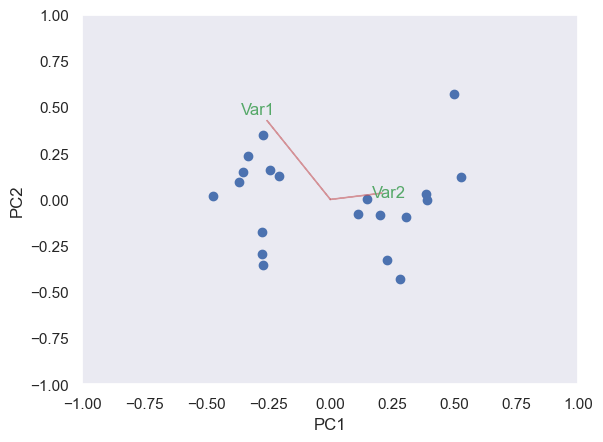

In [162]:
myplot(df_train2c[['var1', 'var2']].values, pca.components_)

In [155]:
get_info(df_train2c[['var1', 'var2']].astype(float))

,count,nunique,mean,range,std,varience,min,25%,50%,75%,max,skew,kurt,sem,sum,mode1,mode2,mode3
var1,20.0,20,7.771561e-17,6.450363,2.155190,4.644846,-3.049508,-1.784098,-0.313868,1.839749,3.400855,0.190587,-1.63687,0.481915,-2.886580e-15,-3.049508,-2.363677,-2.276803
var2,20.0,20,-2.775558e-18,5.608730,1.379706,1.903589,-2.421098,-0.643733,0.052292,0.751841,3.187631,0.222154,0.31128,0.308512,-9.436896e-16,-2.421098,-1.995316,-1.850290


## 2.3. Провести визуальную классификацию данных, спроектированных в пространство первых двух главных компонент. 

In [ ]:
sns.scatterplot(data=df_train2c, x='var1', y='var2', hue='cls')

In [ ]:
df_test2c = pd.DataFrame(pca.transform(
    stand_scaler.transform(df_test[column_names])
    ), columns=['var1', 'var2'])
df_test2c

In [ ]:
sns.scatterplot(data=df_test2c, x='var1', y='var2')

## 2.4. Какую часть дисперсии объясняют эти компоненты. 


In [ ]:
pca = PCA(n_components=8)
pca.fit(df_train_norm)
pca.explained_variance_ratio_[:2].sum()

## 2.5. Сколько компонент необходимо для объяснения 90% дисперсии (p’-?). 

In [ ]:
pca = PCA(n_components=8)
pca.fit(df_train_norm)
pca.explained_variance_ratio_[:4].sum()